In [2]:
%%capture
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [3]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 17.30 MiB/s, done.


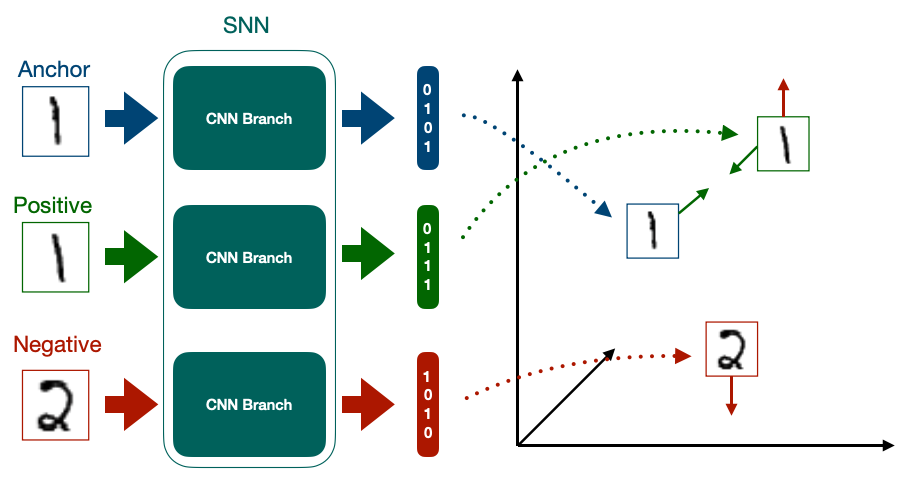

# Imports

In [4]:
import sys 
sys.path.append('/content/Person-Re-Id-Dataset')

In [5]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 

# Configurations

In [7]:
DATA_DIR  = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 25

DEVICE = 'cuda'

In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [9]:
row = df.iloc[8]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

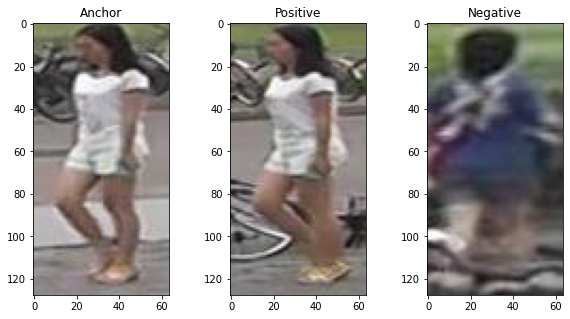

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [17]:
train_df, valid_df = train_test_split(df,test_size= 0.20, random_state= 42)

# Create APN Dataset 

In [18]:
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    return A_img, P_img, N_img

In [19]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

Size of trainset: 3200
Size of validset: 800


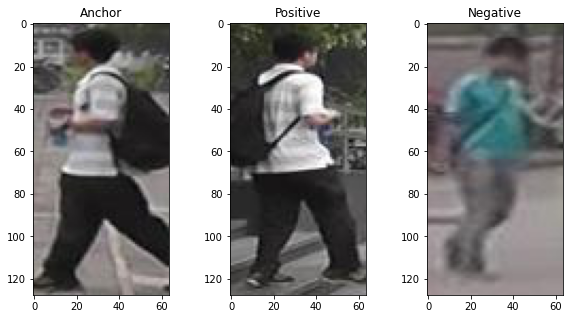

In [21]:
idx = 300
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [23]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [24]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [25]:
for A, P, N in trainloader:
  break;
    
print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model 

In [28]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)

    return embeddings

In [32]:
model = APN_Model()
model.to(DEVICE);

# Create Train and Eval function

In [33]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train() #will turn ON the Dropout layer
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):

    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
    A_embs, P_embs, N_embs = model(A), model(P), model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)


In [36]:
def eval_fn(model, dataloader, criterion):

  model.eval() #will turn OFF the Dropout layer
  total_loss = 0.0

  with torch.no_grad():

    for A, P, N in tqdm(dataloader):

      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
      A_embs, P_embs, N_embs = model(A), model(P), model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [37]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [38]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("Weight Saved Succesfully!")

  print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")


100%|██████████| 25/25 [00:02<00:00, 11.30it/s]


Weight Saved Succesfully!
EPOCHS : 1 train_loss : 0.5351482325792313 valid_loss : 0.5011369287967682


100%|██████████| 25/25 [00:02<00:00, 11.23it/s]


Weight Saved Succesfully!
EPOCHS : 2 train_loss : 0.26236402153968813 valid_loss : 0.2559002238512039


100%|██████████| 25/25 [00:02<00:00, 11.24it/s]


Weight Saved Succesfully!
EPOCHS : 3 train_loss : 0.11795661464333534 valid_loss : 0.23200660169124604


100%|██████████| 25/25 [00:02<00:00, 11.47it/s]


EPOCHS : 4 train_loss : 0.11930336318910122 valid_loss : 0.2683673444390297


100%|██████████| 25/25 [00:02<00:00, 11.45it/s]


EPOCHS : 5 train_loss : 0.1109596972167492 valid_loss : 0.2582673102617264


100%|██████████| 25/25 [00:02<00:00, 11.47it/s]


Weight Saved Succesfully!
EPOCHS : 6 train_loss : 0.07362229347229005 valid_loss : 0.16326706290245055


100%|██████████| 25/25 [00:02<00:00, 10.86it/s]


Weight Saved Succesfully!
EPOCHS : 7 train_loss : 0.0622416864335537 valid_loss : 0.12617120563983916


100%|██████████| 25/25 [00:02<00:00, 11.28it/s]


EPOCHS : 8 train_loss : 0.044023546874523166 valid_loss : 0.13902388036251068


100%|██████████| 25/25 [00:02<00:00, 11.26it/s]


Weight Saved Succesfully!
EPOCHS : 9 train_loss : 0.03133832655847073 valid_loss : 0.12194131702184677


100%|██████████| 25/25 [00:02<00:00, 10.15it/s]


Weight Saved Succesfully!
EPOCHS : 10 train_loss : 0.018413866758346557 valid_loss : 0.09805683672428131


100%|██████████| 25/25 [00:02<00:00, 11.23it/s]


EPOCHS : 11 train_loss : 0.020737247467041017 valid_loss : 0.10057468205690384


100%|██████████| 25/25 [00:02<00:00, 11.38it/s]


EPOCHS : 12 train_loss : 0.013946657478809356 valid_loss : 0.1246609091758728


100%|██████████| 25/25 [00:02<00:00, 11.21it/s]


EPOCHS : 13 train_loss : 0.014670808613300324 valid_loss : 0.1151289501786232


100%|██████████| 25/25 [00:02<00:00, 11.46it/s]


Weight Saved Succesfully!
EPOCHS : 14 train_loss : 0.026139115765690803 valid_loss : 0.08805556774139404


100%|██████████| 25/25 [00:02<00:00, 11.35it/s]


EPOCHS : 15 train_loss : 0.038711944818496706 valid_loss : 0.09593292355537414


100%|██████████| 25/25 [00:02<00:00, 11.33it/s]


EPOCHS : 16 train_loss : 0.07187293916940689 valid_loss : 0.1321437907218933


100%|██████████| 25/25 [00:02<00:00, 11.54it/s]


EPOCHS : 17 train_loss : 0.076311961337924 valid_loss : 0.14676112055778504


100%|██████████| 25/25 [00:02<00:00, 11.39it/s]


EPOCHS : 18 train_loss : 0.04679572686553001 valid_loss : 0.08850555747747421


100%|██████████| 25/25 [00:02<00:00,  9.13it/s]


Weight Saved Succesfully!
EPOCHS : 19 train_loss : 0.027307441681623457 valid_loss : 0.08582213431596757


100%|██████████| 25/25 [00:02<00:00, 11.52it/s]


Weight Saved Succesfully!
EPOCHS : 20 train_loss : 0.010363993644714355 valid_loss : 0.07818592846393585


100%|██████████| 25/25 [00:02<00:00, 11.55it/s]


Weight Saved Succesfully!
EPOCHS : 21 train_loss : 0.015909266024827957 valid_loss : 0.0741802829504013


100%|██████████| 25/25 [00:02<00:00, 11.51it/s]


EPOCHS : 22 train_loss : 0.014805698096752166 valid_loss : 0.0979878032207489


100%|██████████| 25/25 [00:02<00:00, 11.42it/s]


EPOCHS : 23 train_loss : 0.0098539686948061 valid_loss : 0.1408300817012787


100%|██████████| 25/25 [00:02<00:00, 11.49it/s]


EPOCHS : 24 train_loss : 0.01805859141051769 valid_loss : 0.11749915480613708


100%|██████████| 25/25 [00:02<00:00, 11.48it/s]

EPOCHS : 25 train_loss : 0.01527681589126587 valid_loss : 0.13456024736166


# Get Anchor Embeddings

In [40]:
def get_encodings_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)

  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0)) #(c,h,w) -> (batchSize(1), c, h, w)
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc

In [41]:
model.load_state_dict(torch.load("/content/best_model.pt"))

df_enc = get_encodings_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:41<00:00, 95.91it/s] 


In [42]:
df_enc.to_csv('Dtatbase.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,1.398924,0.659882,-0.861344,0.232793,0.147683,0.065486,-0.090745,-0.774088,-0.353253,...,0.019220,-0.822472,0.070788,0.333670,1.475589,0.271068,-0.585559,0.765901,0.852245,-0.456937
1,1420_c3s3_061978_03.jpg,0.604023,0.127192,-0.408863,0.128099,-0.378919,0.029892,-0.446253,-0.388549,-0.329696,...,0.147371,-0.425020,-0.446887,0.032928,1.708303,0.338624,-0.765877,0.827612,0.723202,-0.193397
2,1420_c5s3_062565_05.jpg,0.977062,0.314024,-0.603947,0.184163,-0.146112,-0.047345,-0.334409,-0.536611,-0.265492,...,0.037554,-0.615046,-0.189882,0.237060,1.606228,0.421169,-0.648541,0.675119,0.823232,-0.188172
3,1420_c6s3_085592_04.jpg,1.397696,0.568363,-0.504235,0.325170,0.161446,0.094699,-0.256181,-0.972723,-0.380929,...,-0.077425,-0.669525,-0.233524,0.138897,1.524806,0.160611,-0.657051,0.850134,0.876532,-0.320027
4,0663_c5s3_085987_03.jpg,0.675050,-0.443582,0.778841,0.838450,0.109489,0.223853,0.812103,0.184274,-0.347492,...,0.400208,-0.154467,0.003045,-0.189314,-1.204207,-0.767512,-0.064622,-0.074056,-0.674182,-0.117120


# Inference

In [43]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot((img_enc - anc_enc_arr) , (img_enc - anc_enc_arr).T))
  return dist

In [55]:
idx = 15

img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()

with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [58]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [59]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
  distance = np.append(distance, dist)

In [60]:
closest_idx = np.argsort(distance)

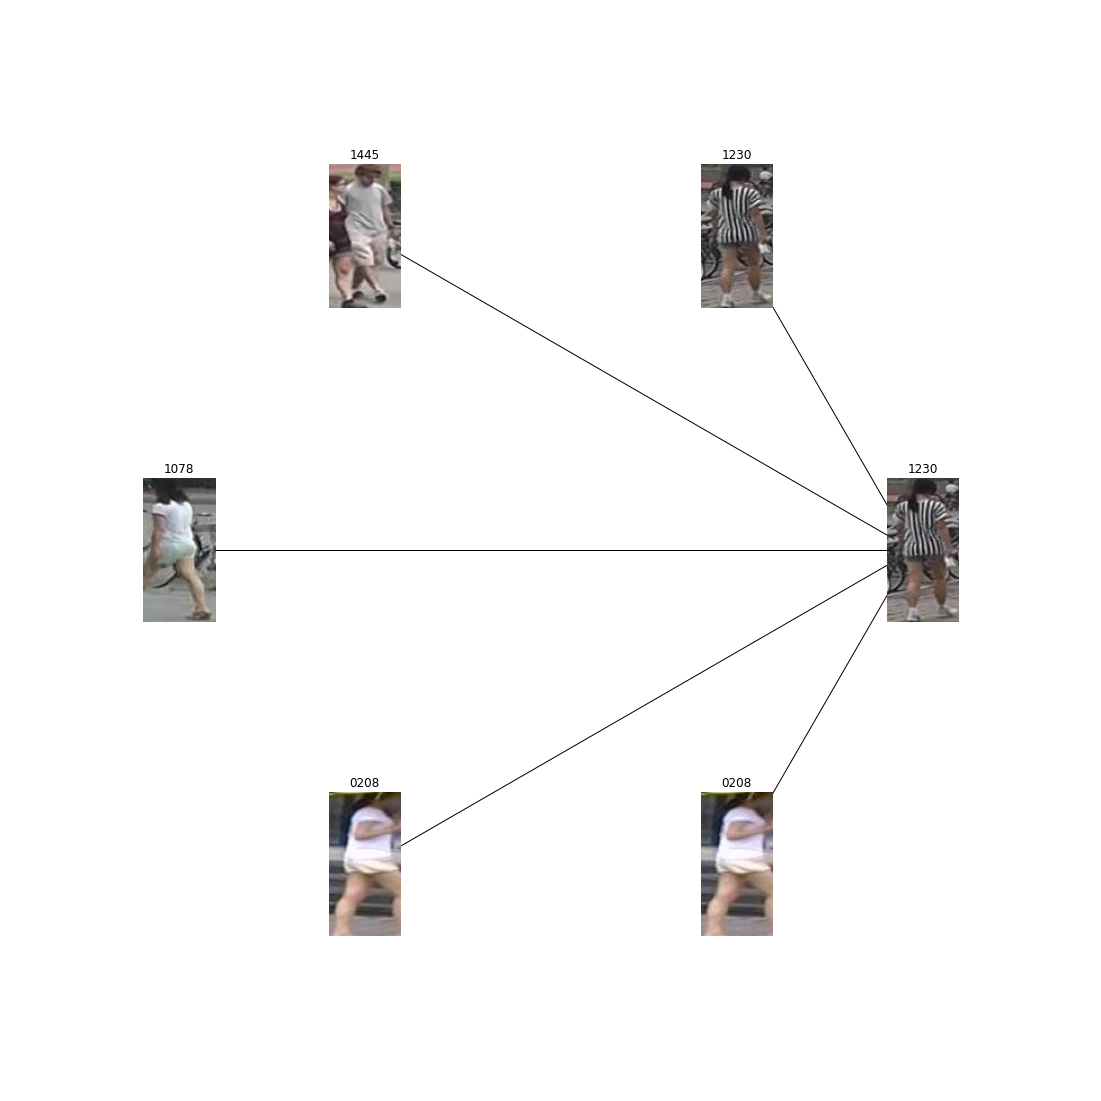

In [61]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);